## GDS

In [15]:
import json 
import pandas as pd
from neo4j import GraphDatabase
import seaborn as sns
sns.set()

### Connect

In [16]:
driver = GraphDatabase.driver(uri = "bolt://localhost:7687",\
                              auth = ("neo4j","12341234"))

In [17]:
driver.verify_connectivity()

<ipython-input-17-b734c674563a>:1: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


'Neo4j/5.4.0'

### Link Prediction (Proteins to PTM_Types)

In [18]:
query = "MATCH (p:Protein) RETURN p.UID"

res = []
with driver.session() as session:
    info = session.run(query)
    for item in info:
        res.append({"ID":item.values()[0]})
dfp = pd.DataFrame(res)
dfp.shape

(56985, 1)

In [19]:
dfp.to_csv("data/ProteinID.csv",index=False)

In [20]:
query = "MATCH (ptm:PTM_Type) RETURN ptm.PTMID"

res = []
with driver.session() as session:
    info = session.run(query)
    for item in info:
        res.append({"ID":item.values()[0]})
dfptm = pd.DataFrame(res)
dfptm.shape

(570, 1)

In [21]:
dfptm.to_csv("data/PTMID.csv",index=False)

In [45]:
res = []

for p in dfp[0:10]["ID"]:
    for pt in dfptm[0:10]["ID"]:
    
        query = "MATCH (p:Protein {UID: '" + p + "'}) \
        MATCH (ptm:PTM_Type {PTMID: '" + pt + "'}) \
        RETURN gds.alpha.linkprediction.totalNeighbors(p, ptm, \
        {relationshipQuery: null})\
        AS Score, p.UID AS Protein, ptm.PTMID AS PTM_Type"

        with driver.session() as session:
            info = session.run(query)
            for item in info:
                res.append({"Protein":item.values()[1], 
                            "PTM_Type":item.values()[2],
                            "Score":item.values()[0]})

In [46]:
df_res = pd.DataFrame(res)
df_res = df_res.sort_values("Score", ascending = False)
df_res.head(5)

,Protein,PTM_Type,Score
8,P63261,PTM-0306,139.0
4,P63261,PTM-0371,133.0
3,P63261,PTM-0369,122.0
5,P63261,PTM-0477,101.0
7,P63261,PTM-0336,96.0


In [47]:
df_pivot = df_res.pivot(index="Protein", columns="PTM_Type", values="Score")
df_pivot.head(15)

PTM_Type,PTM-0306,PTM-0312,PTM-0336,PTM-0337,PTM-0368,PTM-0369,PTM-0371,PTM-0450,PTM-0476,PTM-0477
Protein,,,,,,,,,,
O42422,65.0,10.0,22.0,22.0,11.0,48.0,59.0,10.0,19.0,27.0
P28317,59.0,4.0,16.0,16.0,5.0,42.0,53.0,4.0,13.0,21.0
P30987,70.0,15.0,27.0,27.0,16.0,53.0,64.0,15.0,24.0,32.0
P63261,139.0,84.0,96.0,96.0,85.0,122.0,133.0,84.0,93.0,101.0
Q38933,57.0,2.0,14.0,14.0,3.0,40.0,51.0,2.0,11.0,19.0
Q57NN5,57.0,2.0,14.0,14.0,3.0,40.0,51.0,2.0,11.0,19.0
Q8BWY3,77.0,22.0,34.0,34.0,23.0,60.0,71.0,22.0,31.0,39.0
Q91YT7,67.0,12.0,24.0,24.0,13.0,50.0,61.0,12.0,21.0,29.0
Q92785,64.0,9.0,21.0,21.0,10.0,47.0,58.0,9.0,18.0,26.0


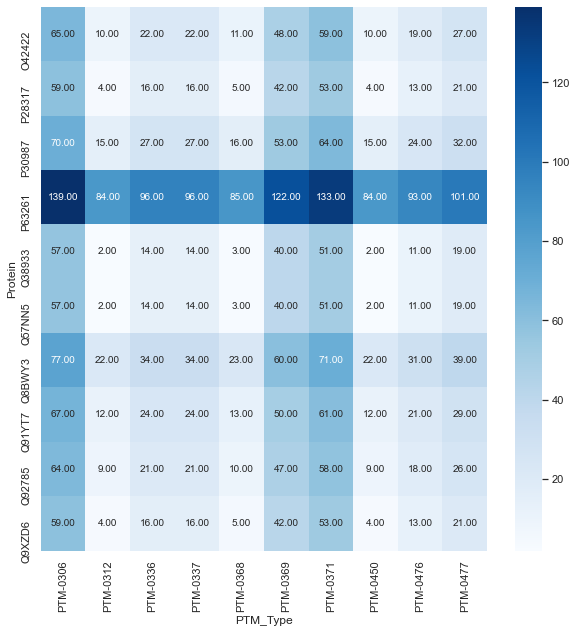

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize = [10,10])
sns.heatmap(df_pivot,cmap="Blues", annot=True, fmt=".2f")
plt.savefig("plots/link-prediction-p2ptm.pdf")
plt.savefig("plots/link-prediction-p2ptm.png")

### Link Prediction: Protein to PTM_Type (Specialized)